In [1]:
# Standard imports
import numpy as np
import yaml
import toml
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top

In [2]:
yaml_file = 'SAT_pole_20210401.yaml'
dd = yaml.safe_load(open(yaml_file))
version_date = str(dd['version']['date'])
version_telescope = str(dd['version']['name'])
del dd['version']

#add fixed psats
psat ={}
psat['SAT_pole_20210401'] = [1.40, 6.13, 7.40, 12.25, 7.65, 13.30, 29.88, 39.03]
psat['SPLAT_20210401'] = [0.42, 0.69, 4.32, 4.65, 11.49, 29.31, 40.02]
psat['CHLAT_20210401'] = [0.72, 3.84, 4.47, 13.95, 41.52, 60.78]

dd['instrument']['channel_default']['psat'] = psat[yaml_file.partition('.')[0]]

# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'

in_param = 'pwv'
base_value = dd['instrument'][in_param]
param_vec = np.arange(500,8000,100)
# in_param possible values:
#  'band_response', 'num_wafer_per_optics_tube', 'num_optics_tube', 
#  'waist_factor', 'psat', 'psat_factor', 'carrier_index', 'Tc', 'Tc_fraction', 
#  'G', 'Flink', 'Yield', 'response_factor', 'bolo_resistance', 'read_frac'

out_param = 'NET' #
# out_param possible values:
#  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
#  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

In [3]:
ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
outputs = {}
outputs[out_param]={}
for chan in ch_names:
    outputs[out_param][chan]=np.array([])

for param_value in param_vec:
    dd['instrument'][in_param] = param_value
    top = Top(**dd)
    top.run()
    tabs = top.instrument.tables
    for chan in ch_names:
        outputs[out_param][chan] = np.append(outputs[out_param][chan], tabs['cam_1_%s_sims' % chan][out_param].quantity[0])

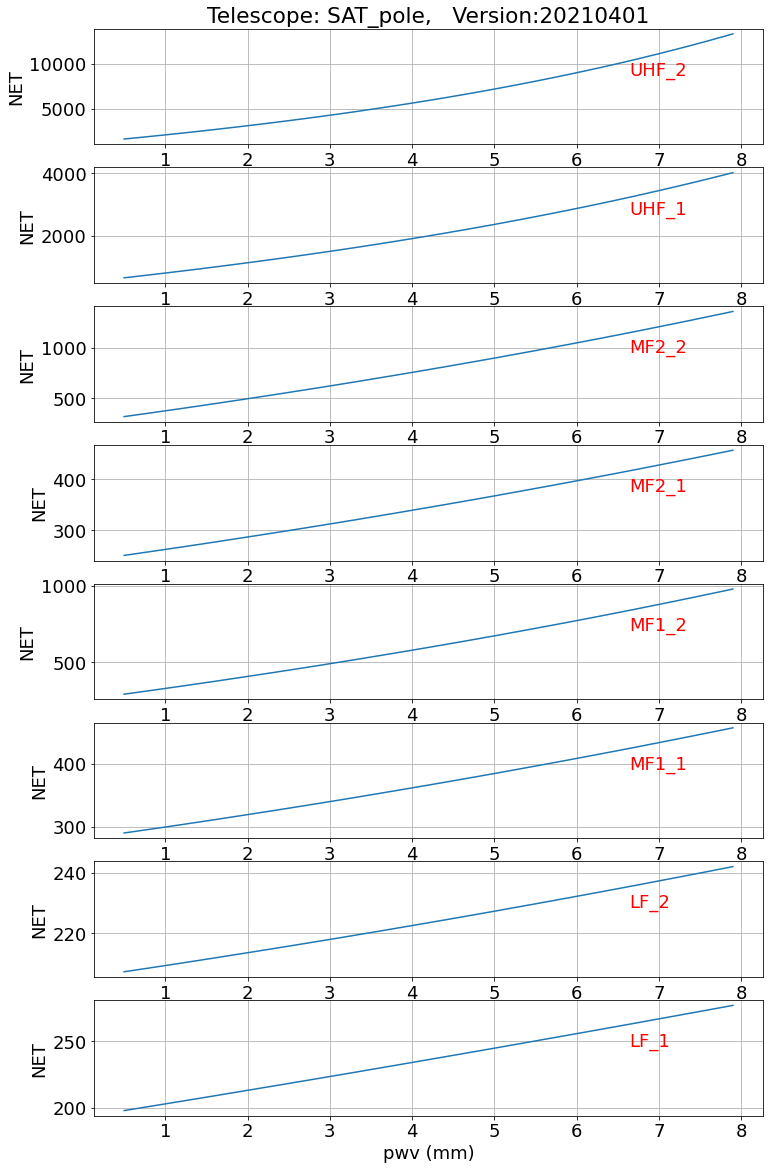

In [4]:
plt.clf()
n_chan = len(ch_names)
ii = n_chan

for chan in ch_names:
    plt.subplot(n_chan,1,ii)
    plt.plot(param_vec / 1000 ,outputs[out_param][chan]) #scale micron to mm
    plt.ylabel(out_param)
    if ii == n_chan:
        plt.xlabel(in_param + ' (mm)')
    xmin, xmax, ymin, ymax = plt.axis()
    #plt.plot([base_value,base_value],[ymin,ymax],'r')
    xloc = xmin + 0.8*(xmax-xmin)
    yloc = ymin + 0.6*(ymax-ymin)
    plt.text(xloc,yloc,chan,color='r')
    plt.grid()
    ii = ii-1
titlestring = 'Telescope: '+version_telescope+',   Version:'+version_date
plt.title(titlestring)
plt.savefig('plots/' + yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.png', dpi=300)

In [5]:
toml_output ={}
toml_output['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
toml_output['input_id'] = version_date
toml_output['variation'] = out_param + '_v_' + in_param
toml_output['telescope'] = version_telescope
toml_output[in_param] = param_vec
for key in ch_names:
    toml_output[key] = np.array(outputs[out_param][key])
    
output_file_name = yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(toml_output, toml_file)